# Implementation 2: CNN model with saliency map

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


To access the dataset, plick click [here](https://drive.google.com/drive/folders/1lJiRkmPPfvwAyMVUfUunKgmYeorQ5R3e?usp=sharing) and add the shorcut named 'FYP_Dataset' to your drive.

In [ ]:
%cd /content/drive/My Drive/FYP_Dataset/data-1/

/content/drive/My Drive/FYP_Dataset/data-1


### Directory Definition

In [ ]:
import os
cwd = os.getcwd()
data1_dir = os.path.join(cwd, 'imgs')
train_dir = os.path.join(cwd, 'train')
val_dir = os.path.join(cwd, 'validation')
test_dir = os.path.join(cwd, 'test')

### Data Generator

In [ ]:
from keras.utils import to_categorical
from keras.api._v2.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        'validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        shuffle=False)

# Convert integer labels to one-hot encoded vectors
train_labels = to_categorical(train_generator.classes, num_classes=36)
validation_labels = to_categorical(validation_generator.classes, num_classes=36)
test_labels = to_categorical(test_generator.classes, num_classes=36)

Found 573 images belonging to 36 classes.
Found 144 images belonging to 36 classes.
Found 36 images belonging to 36 classes.


In [ ]:
import numpy as np

# assume that `train_generator` is your training data generator
train_labels = train_generator.classes
print(np.unique(train_labels))  # should show 36 unique labels

# assume that `val_generator` is your validation data generator
validation_labels = validation_generator.classes
print(np.unique(validation_labels))  # should show 36 unique labels


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


### CNN Model

In [ ]:
import tensorflow as tf
# replace tensorflow.keras with keras.api._v2.keras
from keras.api._v2.keras import layers
from keras.api._v2.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D
from keras.models import Model

In [ ]:
filepath = '/content/drive/MyDrive/FYP Year 3/Coding/models/m8.h5'

In [ ]:
import keras
best_model = keras.models.load_model(filepath)

In [ ]:
saliency_model = keras.models.load_model('/content/drive/MyDrive/FYP Year 3/Coding/models/m3.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

test_images, test_labels = test_generator.next()

print(test_generator.samples)


36


In [ ]:
# get the predictions for the test images
predictions = best_model.predict(test_images)

# convert the one-hot encoded labels back to integer labels
test_labels = np.argmax(test_labels, axis=1)
predicted_labels = np.argmax(predictions, axis=1)


1/1 [==============================] - 9s 9s/step


In [ ]:
pred_saliency_maps = saliency_model.predict(test_images)

1/1 [==============================] - 3s 3s/step


In [ ]:
import cv2
img_size = (224, 224)
pred_saliency_maps_resized = []
for pred_map in pred_saliency_maps:
    resized_map = cv2.resize(pred_map, img_size, interpolation=cv2.INTER_LINEAR)
    pred_saliency_maps_resized.append(resized_map)

pred_saliency_maps_resized = np.array(pred_saliency_maps_resized)

In [ ]:
import numpy as np
pred_saliency_maps_binary = np.where(pred_saliency_maps_resized > 0.5, 1, 0)

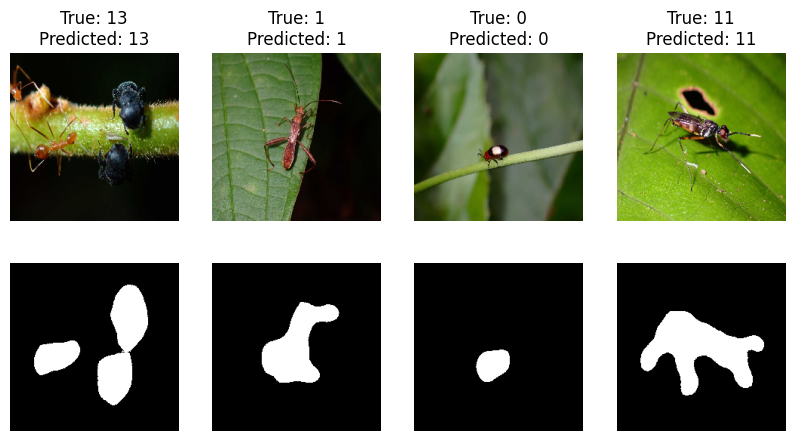

In [ ]:
# plot the first five test images along with corresponding training images that have the same true label
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    idx = random.randint(0, 15)
    # plot the original image
    axs[0, i].imshow(test_images[idx])
    axs[0, i].axis('off')
    # get the original and predicted labels
    true_label = test_labels[idx]
    predicted_label = predicted_labels[idx]
    # add the labels to the plot
    axs[0, i].set_title('True: {}\nPredicted: {}'.format(true_label, predicted_label))
    axs[1, i].imshow(pred_saliency_maps_binary[idx], cmap = 'gray')
    axs[1, i].axis('off')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate the evaluation metrics for the test set
test_accuracy = accuracy_score(test_labels, predicted_labels)
test_f1_score = f1_score(test_labels, predicted_labels, average='weighted')
test_precision = precision_score(test_labels, predicted_labels, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, predicted_labels, average='weighted', zero_division=0)


# print the evaluation metrics
print('Test Accuracy: {:.2f}%'.format(test_accuracy*100))
print('Test F1 Score: {:.2f}%'.format(test_f1_score*100))
print('Test Precision: {:.2f}%'.format(test_precision*100))
print('Test Recall: {:.2f}%'.format(test_recall*100))



Test Accuracy: 75.00%
Test F1 Score: 71.88%
Test Precision: 70.83%
Test Recall: 75.00%
